Bryan Werth 
Report03

In [2]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
from scipy.stats import poisson
from scipy.special import binom

from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeExponentialPmf, EvalExponentialCdf
from thinkbayes2 import MakePoissonPmf as PoissonPmf
from thinkbayes2 import MakeBinomialPmf, EvalPoissonPmf
import thinkplot

**Exercise** [This study from 2015](http://onlinelibrary.wiley.com/doi/10.1111/apt.13372/full) showed that many subjects diagnosed with non-celiac gluten sensitivity (NCGS) were not able to distinguish gluten flour from non-gluten flour in a blind challenge.

Here is a description of the study:

>"We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.
>"The gluten-containing ﬂour was correctly identiﬁed by 12 participants (34%)..."
Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

We can use a Bayesian approach to interpret the results more precisely.  But first we have to make some modeling decisions.

1. Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple I follow the authors of the study and lump together the second two groups; that is, I consider two groups: those who identified the gluten flour and those who did not.

2. I assume (1) people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and (2) subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).

Using this model, estimate the number of study participants who are sensitive to gluten.  What is the most likely number?  What is the 95% credible interval?

To solve this problem, we have to define a Gluten class with its own likelihood method. In this case, the hypothesis is the number of gluten sensitive people and the data is the people who identified and the people who did not identify gluten. We need to calculate the probability of some number of people identifying gluten given the number of glutenSensitive people. We calculate the totalParticipants and the number of people who aren't gluten sensitive (notGlutenSensitive). We then use the predefined MakeBinomialPmf to determine the probability of a certain number of successes in a number of trials given the probability of success. We create a BinomialPmf for both the probable number of people who identified gluten who are gluten sensitive and the number of people who identified gluten who are not gluten sensitive. I then add them and index to return the probability. To test, I define a reasonable prior range, update with the necessary data, and plot before finiding the credible interval as requested. 

(0, 8)

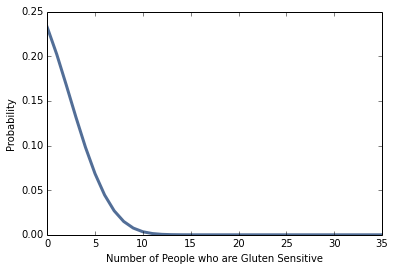

In [30]:
class Gluten(Suite):
    
    def Likelihood(self, data, hypo):
        glutenSensitive = hypo
        identifiedGluten,didNotIdentifyGluten = data
        totalParticipants = identifiedGluten+didNotIdentifyGluten
        notGlutenSensitive = totalParticipants-glutenSensitive
        glutenPmf = MakeBinomialPmf(glutenSensitive,.95)
        nonGlutenPmf = MakeBinomialPmf(notGlutenSensitive,.4)
        totalPmf = glutenPmf+nonGlutenPmf
        return totalPmf[identifiedGluten]

glutenStudy = Gluten(range(0,36))
data = 12,23
glutenStudy.Update(data)
thinkplot.Pdf(glutenStudy)
thinkplot.Config(xlabel='Number of People who are Gluten Sensitive',
                ylabel='Probability')
glutenStudy.CredibleInterval(95)

**Exercise:** Suppose that goal scoring in hockey is well modeled by a 
Poisson process, and that the long-run goal-scoring rate of the
Boston Bruins against the Vancouver Canucks is 2.9 goals per game.
In their next game, what is the probability
that the Bruins score exactly 3 goals?  Plot the PMF of `k`, the number
of goals they score in a game.

For this problem, there is a predefined method that calculates the probability of three goals given the average number of goals per game. This is a method of the poisson class because it is modeled by a poisson process. 

In [7]:
bruinsNextGame = poisson.pmf(3,2.9)
print(bruinsNextGame)

0.223660218993


To define the actual pmf for this poisson process, we use the MakePoissonPmf method from the thinkbayes2 module. The second input is the maximum x value to be plotted. 

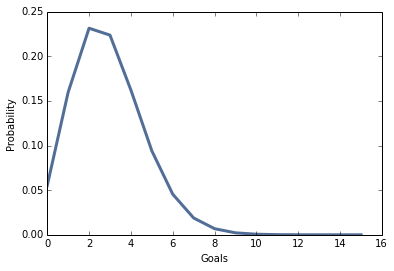

In [32]:
bruinsNextGame = PoissonPmf(2.9,15)
thinkplot.Pdf(bruinsNextGame)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability')

**Exercise:**  Assuming again that the goal scoring rate is 2.9, what is the probability of scoring a total of 9 goals in three games?  Answer this question two ways:

1.  Compute the distribution of goals scored in one game and then add it to itself twice to find the distribution of goals scored in 3 games.

2.  Use the Poisson PMF with parameter $\lambda t$, where $\lambda$ is the rate in goals per game and $t$ is the duration in games.

First, we define the pmf for one game as we did above using the PoissonPmf method. Then we add the defined pmf to itself three times and plot the result using the Pdf method from the thinkplot module. The result is the distribution of goals over three games

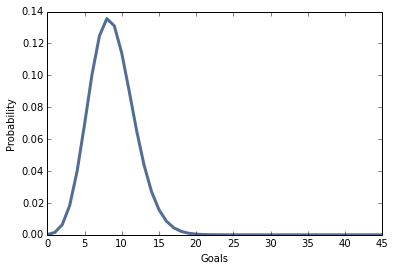

In [33]:
BruinsOneGame = PoissonPmf(2.9,15)
BruinsThreeGames = BruinsOneGame+BruinsOneGame+BruinsOneGame
thinkplot.Pdf(BruinsThreeGames)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability')

The second method is to multiply the average number of goals in one game by three and plot the result using the Pdf method. This method is slightly more concise because defining the Pmf is one line instead of two.

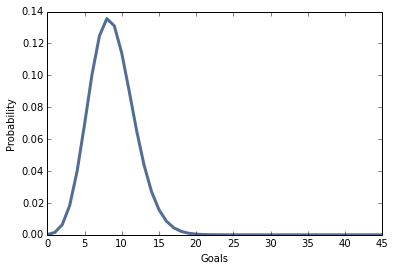

In [34]:
BruinsThreeGamesTwo = PoissonPmf(2.9*3,45)
thinkplot.Pdf(BruinsThreeGamesTwo)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability')

**Exercise:** Suppose that the long-run goal-scoring rate of the
Canucks against the Bruins is 2.6 goals per game.  Plot the distribution
of `t`, the time until the Canucks score their first goal.
In their next game, what is the probability that the Canucks score
during the first period (that is, the first third of the game)?

Hint: `thinkbayes2` provides `MakeExponentialPmf` and `EvalExponentialCdf`.

This question can be best answered by an exponential pmf model. First, we define the exponential pmf using the MakeExponentialPmf method from the ThinkBayes2 module. Lambda is 2.6 and the maximum x value we want to plot is 4. After, we plot the pmf for visualization. Finally we calculate the likelihood of scoring in the first period by using the EvalExponentialCdf method from the ThinkBayes2 module. Because we are referring to the first period, we only want to calculate the probability of scoring within the first third of the game. Also, lambda is 2.6, so the second input is 2.6. 

0.5796496154913181

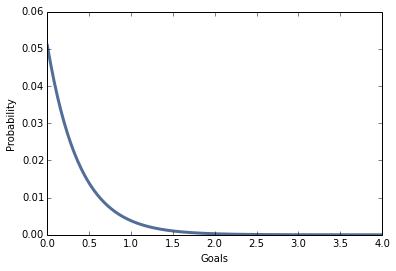

In [35]:
CanucksScores = MakeExponentialPmf(2.6,4)
thinkplot.Pdf(CanucksScores)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability')
EvalExponentialCdf(1/3,2.6)

**Exercise:** Assuming again that the goal scoring rate is 2.8, what is the probability that the Canucks get shut out (that is, don't score for an entire game)?  Answer this question two ways, using the CDF of the exponential distribution and the PMF of the Poisson distribution.

For the first method, we have to evaluate the probability of having 0 events in the length of time that we would normally have 2.8 events. To do this we use the EvalPoissonPmf method.

In [15]:
CanucksScoreOne = EvalPoissonPmf(0,2.8)
print(CanucksScoreOne)

0.0608100626252


For the second method, we can plot the exponential pmf using MakeExponentialPmf method from the thinkbayes2 module. We then use the EvalExponentialCdf as it has been previously used. We subtract the result from one because we can only calculate the probability that the canucks will score over the course of the game. One minus this is the probability they don't. 

0.0608100626252


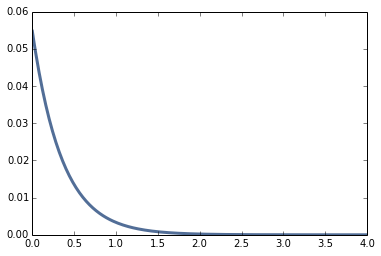

In [12]:
CanucksScore = MakeExponentialPmf(2.8,4)
thinkplot.Pdf(CanucksScore)
CanucksShutOut = 1-EvalExponentialCdf(1,2.8)
print(CanucksShutOut)

**Exercise:** From [John D. Cook](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs.  What is the Bayesian estimate of the number of errors based on this data?

I think I did something wrong with this problem given the result of the initial calculation, but I will explain the process. First, I defined a function for the probability of some number of positive results (k) in another number of trials (n) given the probability of a hit (p). This equation can be found online or in the thinkbayes textbook as seen in the binomial function. Next we define a Suite class with a likelihood function where we break the probability of the data given a hypothesis into three separate parts. The first part is the probability of the first debugger finding k1 number of errors. This is defined as the binomial helper function we have multiplied by the possible number of ways k1 errors could have been found. Prob2 is the same thing with the second debugger. ProbBoth is the probability of both debuggers finding the some number of errors in common c. This is the binomial helper for each of the debuggers and the number of errors in common. Following this I define the hypothesis range by using three nested for loops. I appended combinations of these three loops to a hypos list and used the list to define the prior. Finally, I updated with the known number of found errors and errors in common. I got a weird answer for this and could not find the problem, so I didn't pursue more specific answers.

In [7]:
#p**k * (1-p)**(n-k)

def binomial(k, n, p):
    """Computes the rest of the binomial PMF.

    k: number of hits
    n: number of attempts
    p: probability of a hit
    """
    return p**k * (1-p)**(n-k)

class Debugging(Suite):
    
    def Likelihood(self,data,hypo):
        #data is k1 k2 c where k1 and k2 are the number of bugs found by 
        #each debugger and c is the number of common errors found
        #hypo is p1 p2 n where p1 and p2 is the probability of each 
        #debugger finding an error and n is the number of bugs total
        k1, k2, c = data
        p1, p2, n = hypo
        prob1 = binomial(k1,n,p1)*binom(n,k1)
        prob2 = binomial(k2,n,p2)*binom(n,k2)
        probBoth = binomial(c,n,p1)*binomial(c,n,p2)
        return prob1*prob2*probBoth

pRange = np.linspace(.01,.211,20)
nRange = range(31,400)
hypos = []
for n in nRange:
    for p1 in pRange:
        for p2 in pRange:
            hypos.append((p1, p2,n))
            
debugSuite = Debugging(hypos)
debugSuite.Update((20,15,3))

7.0899341291143316e-21

**Exercise:** To make the model of overtime more correct, we could update both suites with 0 goals in one game, before computing the predictive distribution of `t`.  Make this change and see what effect it has on the results.

The defined Hockey class, MakeGoalPmf function and initial definitions are all copied from the notebook. A further explanation of these aspects of the answer can be found also in the thinkbayes textbook chapter 9. First, I updated each suite as described in the question. I then used the MakeGoalPmf function to define the range of number of goals expected. I took the average of both of these and used it as the new lambda values for each suite. I then defined exponential pmfs for both and plotted them

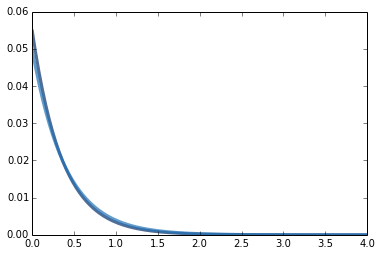

In [10]:
from thinkbayes2 import MakeNormalPmf
from thinkbayes2 import EvalPoissonPmf

class Hockey(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, label=None):
        """Initializes the Hockey object.

        label: string
        """
        mu = 2.8
        sigma = 0.3

        pmf = MakeNormalPmf(mu, sigma, num_sigmas=4, n=101)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one game
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like
    
suite1 = Hockey('bruins')
suite2 = Hockey('canucks')
suite1.UpdateSet([0, 2, 8, 4])
suite2.UpdateSet([1, 3, 1, 0])

from thinkbayes2 import MakeMixture
from thinkbayes2 import MakePoissonPmf

def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

#My Answer Starts Here
suite1.Update(0)
suite2.Update(0)
BruinsGoalUpdated = MakeGoalPmf(suite1)
CanucksGoalUpdated = MakeGoalPmf(suite2)
BruinsLambda = BruinsGoalUpdated.Mean()
CanucksLambda = CanucksGoalUpdated.Mean()
BruinsOvertime = MakeExponentialPmf(BruinsLambda,4)
CanucksOvertime = MakeExponentialPmf(CanucksLambda,4)
thinkplot.Pdf(BruinsOvertime)
thinkplot.Pdf(CanucksOvertime)

**Exercise:** In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. What is the probability that Germany had the better team?  What is the probability that Germany would win a rematch?

For a prior distribution on the goal-scoring rate for each team, use a gamma distribution with parameter 1.3.

To solve this problem, I defined a modified version of the Hockey class. In the init method, I defined a gamma prior as suggested in the problem. I used the MakeGammaPmf method. I used a range of possible x values for number of goals and the average number of goals of 1.3. I then called the Suite init method for the Gamma Pmf. I also defined a new likelihood method. In this likelihood method I used the predefined EvalPoissonPmf to find the likelihood of a given number of goals being scored in a game given an average number of goals per game. Finally I defined a suite for argentina and germany and updated them. 

In [11]:
from thinkbayes2 import MakeGammaPmf
from math import isnan

class Soccers(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, label=None):
        """Initializes the Hockey object.
           label: string
        """
        xs = np.linspace(1, 8, 101)
        pmf = MakeGammaPmf(xs, 1.3)
        Suite.__init__(self, pmf, label=label)
        
    def Update(self, data):
        """Updates each hypothesis based on the data.

        data: any representation of the data

        returns: the normalizing constant
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        return self.Normalize()
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one game
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

Argentina = Soccers()
Germany = Soccers()
Argentina.Update(0)
Germany.Update(1)


0.26681443199784355

**Exercise:** In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game. 

First I defined a Soccer Suite with a new likelihood method. In this method I turned the time between goals into a fraction and used the EvalExponentialCdf to find the probability of the time between goals given the scoring rate. After this, I defined a prior from 0 to 10 as a reasonable range of possible goals. Then I initialized the Soccer Suite with this prior and updated for the time between goals. Then I printed the mean number of goals given the updates. I also calculated the chances that Germany scores more than 5 goals by using the predefined EvalExponentialCdf with an input of .2 which would mean a goal is scored at least every fifth of the game. 

In [12]:
class Soccer(Suite):
    
    def Likelihood(self,data,hypo):
        #The data is the time between goals
        #The hypo is the scoring rate per game
        
        lam = hypo
        t = data
        tFraction = t/90.0
        return EvalExponentialCdf(tFraction,lam)
    
prior = np.linspace(0,10)
Germany = Soccer(prior)
Germany.UpdateSet([11,12])
print(Germany.Mean())
print(EvalExponentialCdf(.2,Germany.Mean()))

7.11415112663
0.758969121062


I am a big football fan. Earlier this year, my Patriots lost to the Bills 16-0 in a blowout loss. This was one of the first honest to goodness wins for the Bills against us in almost a decade. Given known information about past games against the Bills, what is the scoreline of the next game between the two teams going to be?

For this problem, we start by redefining the init method with an input of the average number of goals, a standard deviation, and the number of standard deviations. We calculate this information using the scorelines from every Bills-Patriots game since January 1, 2000. A likelihood method can be defined similar to the likelihood method from the hockey class. We use EvalPoissonPmf to determine the probability of some number of goals being scored in a game given the average scoring rate for the team against the other team. Finally, we define and update iterations of the Football class for the Patriots and the Bills. We take the average of the distribution that results to determine the probable scoreline of 3-16 in favor of the Bills. If I was to pursue this further, a more accurate way of finding the probable scoreline would be to factor in data from the past five games instead of just the one from this season.

In [28]:
from thinkbayes2 import MakeNormalPmf
from thinkbayes2 import EvalPoissonPmf
from thinkbayes2 import MakeMixture
from thinkbayes2 import MakePoissonPmf

class Football(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, mu, sigma, num_sigmas, label=None):
        """Initializes the Hockey object.

        label: string
        """
        pmf = MakeNormalPmf(mu, sigma, num_sigmas, n=101)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one game
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        if np.isnan(like):
            print(k,lam)
        return like

Patriots = Football(27,12.45,2)
Bills = Football(15.73,9.36,1)
Patriots.Update(0)
Bills.Update(16)
Patriots.Mean()


3.0409412490357925

In [29]:
Bills.Mean()

16.480398069592919